# **Pattern Recognition - Series 7**

Part of the content in this notebook originates from two sources: the Stanford course [CS224W: Machine Learning with Graphs](https://web.stanford.edu/class/cs224w/index.html) and the Pytorch-Geometric [tutorial series](https://pytorch-geometric.readthedocs.io/en/latest/).

Within this Colab, we will construct a complete pipeline for **performing graph classification using GNN**.

# **Graph classification using GNN**

In this section, our primary objective is to delve into the application of Graph Neural Networks (GNNs) specifically to the realm of graph classification. Graph classification involves the classification of complete graphs, rather than individual nodes, utilizing a dataset comprising multiple graphs. The classification is based on certain structural properties inherent in the graphs.

Our focus here lies in embedding entire graphs and ensuring that these embeddings enable linear separability, thus facilitating the accomplishment of a particular task.

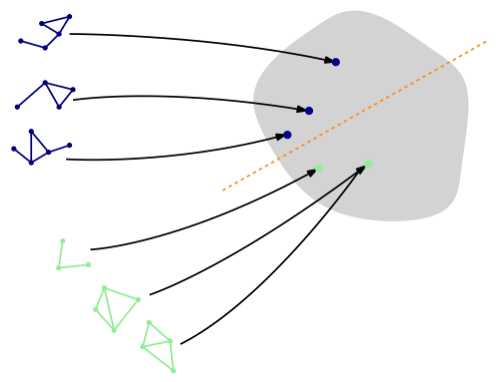

## Setup
Check if PyTorch is properly installed

In [1]:
import os
import pandas as pd
import torch

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# If you use GPU, the device should be cuda
print('Device: {}'.format(device))

2.0.0+cu117
Device: cuda


## TUDATASETS


One of the most prevalent applications for graph classification involves predicting molecular properties. In this particular task, molecules are represented as graphs, and the objective is to determine whether a given molecule inhibits HIV virus replication or not.

To facilitate research and experimentation in this field, the TU Dortmund University has curated an extensive collection of diverse graph classification datasets, known as the [**TUDatasets**](https://chrsmrrs.github.io/datasets/).

Let's proceed by loading and examining one of the smaller datasets from this collection, known as the **MUTAG dataset**.

In [2]:
from torch_geometric.datasets import TUDataset

root = '.data/TUDataset'
name = 'MUTAG'

# The MUTAG dataset
pyg_dataset= TUDataset(root, name)

# You will find that there are 600 graphs in this dataset
print(pyg_dataset)

MUTAG(188)


### 2.1 What is the number of classes and number of features in the MUTAG dataset?

In [3]:
def get_num_classes(pyg_dataset):
  # TODO: Implement a function that takes a PyG dataset object
  # and returns the number of classes for that dataset.

  num_classes = 0

  ############# Your code here ############
  num_classes = pyg_dataset.num_classes
  #########################################

  return num_classes

def get_num_features(pyg_dataset):
  # TODO: Implement a function that takes a PyG dataset object
  # and returns the number of features for that dataset.

  num_features = 0

  ############# Your code here ############
  num_features = pyg_dataset.num_features
  #########################################

  return num_features

num_classes = get_num_classes(pyg_dataset)
num_features = get_num_features(pyg_dataset)
print("{} dataset has {} classes".format(name, num_classes))
print("{} dataset has {} features".format(name, num_features))

MUTAG dataset has 2 classes
MUTAG dataset has 7 features


### PyG Data

Each PyG dataset stores a list of `torch_geometric.data.Data` objects, where each `torch_geometric.data.Data` object represents a graph. We can easily get the `Data` object by indexing into the dataset.

For more information such as what is stored in the `Data` object, please refer to the [documentation](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data).

### 2.2 What is the label of the graph with index 100 in the MUTAG dataset?

In [4]:
def get_graph_class(pyg_dataset, idx):
  # TODO: Implement a function that takes a PyG dataset object,
  # an index of a graph within the dataset, and returns the class/label 
  # of the graph (as an integer).

  label = -1

  ############# Your code here ############
  label = pyg_dataset[idx].y[0]
  #########################################

  return label

# Here pyg_dataset is a dataset for graph classification
graph_0 = pyg_dataset[0]
print(graph_0)
idx = 100
label = get_graph_class(pyg_dataset, idx)
print('Graph with index {} has label {}'.format(idx, label))

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Graph with index 100 has label 1


### 2.3 How many edges does the graph with index 50 have?

In [5]:
def get_graph_num_edges(pyg_dataset, idx):
  # TODO: Implement a function that takes a PyG dataset object,
  # the index of a graph in the dataset, and returns the number of 
  # edges in the graph (as an integer). You should not count an edge 
  # twice if the graph is undirected. For example, in an undirected 
  # graph G, if two nodes v and u are connected by an edge, this edge
  # should only be counted once.

  num_edges = 0

  ############# Your code here ############
  ## Note:
  ## 1. You can't return the data.num_edges directly
  ## 2. We assume the graph is undirected
  ## 3. Look at the PyG dataset built in functions
  num_edges = pyg_dataset[idx].num_edges // 2

  #########################################

  return num_edges

idx = 50
num_edges = get_graph_num_edges(pyg_dataset, idx)
print('Graph with index {} has {} edges'.format(idx, num_edges))

Graph with index 50 has 30 edges


## GCN Model - Graph classification

Now we will implement our GCN model!

Please follow the figure below to implement the `forward` function.


![test](https://drive.google.com/uc?id=128AuYAXNXGg7PIhJJ7e420DoPWKb-RtL)

### 2.4 Create the GCN model

In [6]:
import torch.nn.functional as F

# The PyG built-in GCNConv
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(
        self,
        input_dim,
        hidden_dim,
        output_dim,
        num_layers,
        dropout,
        return_embeds=False,
    ):
        # TODO: Implement a function that initializes self.convs,
        # self.bns, and self.softmax.

        super(GCN, self).__init__()

        # A list of GCNConv layers
        self.convs = None

        # A list of 1D batch normalization layers
        self.bns = None

        # The log softmax layer
        self.softmax = None

        ############# Your code here ############
        ## Note:
        ## 1. You should use torch.nn.ModuleList for self.convs and self.bns
        ## 2. self.convs has num_layers GCNConv layers
        ## 3. self.bns has num_layers - 1 BatchNorm1d layers
        ## 4. You should use torch.nn.LogSoftmax for self.softmax
        ## 5. The parameters you can set for GCNConv include 'in_channels' and
        ## 'out_channels'. For more information please refer to the documentation:
        ## https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv
        ## 6. The only parameter you need to set for BatchNorm1d is 'num_features'
        ## For more information please refer to the documentation:
        ## https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html
        self.convs = torch.nn.ModuleList(
            [GCNConv(in_channels=input_dim, out_channels=hidden_dim)]
            + [
                GCNConv(in_channels=hidden_dim, out_channels=hidden_dim)
                for i in range(num_layers - 2)
            ]
            + [GCNConv(in_channels=hidden_dim, out_channels=output_dim)]
        )

        self.bns = torch.nn.ModuleList(
            [
                torch.nn.BatchNorm1d(num_features=hidden_dim)
                for i in range(num_layers - 1)
            ]
        )

        self.softmax = torch.nn.LogSoftmax(dim=1)

        #########################################

        # Probability of an element getting zeroed
        self.dropout = dropout

        # Skip classification layer and return node embeddings
        self.return_embeds = return_embeds

        self.num_layers = num_layers

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adj_t):
        # TODO: Implement a function that takes the feature tensor x and
        # edge_index tensor adj_t and returns the output tensor as
        # shown in the figure.

        out = None

        ############# Your code here ############
        ## Note:
        ## 1. Construct the network as shown in the figure
        ## 2. torch.nn.functional.relu and torch.nn.functional.dropout are useful
        ## For more information please refer to the documentation:
        ## https://pytorch.org/docs/stable/nn.functional.html
        ## 3. Don't forget to set F.dropout training to self.training
        ## 4. If return_embeds is True, then skip the last softmax layer
        for i in range(self.num_layers):
            # Last Conv layer pass
            if i == self.num_layers - 1:
                x = self.convs[i](x, adj_t)
                if self.return_embeds:
                    return x
                x = self.softmax(x)
                out = x

            else:
                x = self.convs[i](x, adj_t)
                x = self.bns[i](x)
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)

        #########################################

        return out


### 2.5 GNN: Graph Property Prediction

In this section we will create a graph neural network for graph property prediction (graph classification).


In [7]:
from torch_geometric.nn import global_mean_pool

### GCN to perform graph classification
class GCN_Graph(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(GCN_Graph, self).__init__()

        # Node embedding model
        # Note that the input_dim and output_dim are set to hidden_dim
        self.gnn_node = GCN(input_dim, hidden_dim,
            hidden_dim, num_layers, dropout, return_embeds=True)

        self.pool = None

        ############# Your code here ############
        ## Note:
        ## 1. Initialize self.pool as a global mean pooling layer
        ## For more information please refer to the documentation:
        ## https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#global-pooling-layers
        self.pool = global_mean_pool

        #########################################

        # Output layer
        self.linear = torch.nn.Linear(hidden_dim, output_dim)


    def reset_parameters(self):
      self.gnn_node.reset_parameters()
      self.linear.reset_parameters()

    def forward(self, batched_data):
        # TODO: Implement a function that takes as input a 
        # mini-batch of graphs (torch_geometric.data.Batch) and 
        # returns the predicted graph property for each graph. 
        #
        # NOTE: Since we are predicting graph level properties,
        # your output will be a tensor with dimension equaling
        # the number of graphs in the mini-batch

    
        # Extract important attributes of our mini-batch
        x, edge_index, batch = batched_data.x, batched_data.edge_index, batched_data.batch

        out = None

        ############# Your code here ############
        ## Note:
        ## 1. Construct node embeddings using existing GCN model
        ## 2. Use the global pooling layer to aggregate features for each individual graph
        ## For more information please refer to the documentation:
        ## https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#global-pooling-layers
        ## 3. Use a linear layer to predict each graph's property
        out = self.gnn_node(x, edge_index)
        out = self.pool(out, batch)
        out = self.linear(out)

        #########################################

        return out

### Preprocess the MUTAG dataset


In [8]:
from torch_geometric.loader import DataLoader

# Set the random seed for reproducibility
torch.manual_seed(12345)

dataset = pyg_dataset
# Shuffle the dataset to randomize the order of samples
dataset = dataset.shuffle()

# Create a data loader for training with a batch size of 64 and shuffled batches
train_loader = DataLoader(dataset[:150], batch_size=64, shuffle=True)
# Create a data loader for testing with a batch size of 64 and non-shuffled batches
test_loader = DataLoader(dataset[150:], batch_size=64, shuffle=False)

### 2.6 Train the GNN_Graph model

Train your network for a few epochs to see how well it performs on the training as well as test set.


In [9]:
model = GCN_Graph(input_dim=dataset.num_node_features,
                  hidden_dim=32,
                  output_dim=dataset.num_classes,
                  num_layers=3,
                  dropout=0.25).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()
n_epochs = 50

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.

        ############# Your code here ############
        ## Note: 
        ## 1. Get the output of a single forward pass of the current data in your model
        ## 2. Feed the output into the loss_fn
        ## 3. Update the model using the loss and optimizer
        data = data.to(device)
        out = model(data)
        optimizer.zero_grad()
        loss = loss_fn(out, data.y)
        loss.backward()
        optimizer.step()

        #########################################


def test(loader):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        data = data.to(device)
        out = model(data)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, n_epochs+1):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 002, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 003, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 004, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 005, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 006, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 007, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 008, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 009, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 010, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 011, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 012, Train Acc: 0.6533, Test Acc: 0.7368
Epoch: 013, Train Acc: 0.6667, Test Acc: 0.7368
Epoch: 014, Train Acc: 0.7333, Test Acc: 0.7632
Epoch: 015, Train Acc: 0.7600, Test Acc: 0.7632
Epoch: 016, Train Acc: 0.7600, Test Acc: 0.7632
Epoch: 017, Train Acc: 0.7533, Test Acc: 0.7895
Epoch: 018, Train Acc: 0.7400, Test Acc: 0.7632
Epoch: 019, Train Acc: 0.7200, Test Acc: 0.7632
Epoch: 020, Train Acc: 0.7200, Test Acc: 0.7632
Epoch: 021, Train Acc: 0.7133, Test Acc: